In [ ]:
pip install google-api-python-client nltk

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')   # <-- add this line
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
pip install youtube_comment_downloader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 7.6 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
from youtube_comment_downloader import YoutubeCommentDownloader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ---------------------------
# 1. Fetch comments
# ---------------------------
video_url = "https://www.youtube.com/watch?v=i_LwzRVP7bg&t=9678s"  # replace VIDEO_ID with your video
downloader = YoutubeCommentDownloader()
comments = downloader.get_comments_from_url(video_url, sort_by=0)

data = []
stop_words = set(stopwords.words("english"))

# ---------------------------
# 2. Clean tokens
# ---------------------------
def clean_comment(text):
    # remove emojis & non-alphanumeric
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    # remove stopwords and duplicates while keeping order
    cleaned = [t for t in tokens if t not in stop_words]
    return cleaned

# ---------------------------
# 3. Process comments
# ---------------------------
for c in comments:
    username = "@" + c["author"]
    timestamp = c.get("time", "")  # relative time like '2 years ago'
    comment_text = c["text"]
    cleaned_tokens = clean_comment(comment_text)

    data.append([username, timestamp, comment_text, cleaned_tokens])

# ---------------------------
# 4. Save as CSV
# ---------------------------
df = pd.DataFrame(data, columns=["username", "timestamp_text", "comment_text", "cleaned_tokens"])
df.to_csv("/content/drive/MyDrive/477Project/youtube_comments.csv", index=False)

print(df.head(10))


                  username        timestamp_text  \
0           @@adelinad5102          3 months ago   
1  @@auliamardhatillah2240           2 years ago   
2    @@risebyliftingothers  2 years ago (edited)   
3             @@limwei2634           2 years ago   
4         @@nancykataria08          4 months ago   
5                @@jpbaugh           2 years ago   
6              @@shmasbhai            1 year ago   
7          @@its_krish_666           2 weeks ago   
8              @@jadambang          7 months ago   
9           @@Lodermeier88           2 years ago   

                                        comment_text  \
0  This is definitely not a tutorial for "everyon...   
1  Yesterday I click on a video called 'learning ...   
2  Thanks for an amazingly simplified approach to...   
3  I've been trying to learn ML for quite awhile ...   
4  No fancy words, just simple English and the ri...   
5  For anyone getting an error related to convert...   
6  I think it is a very advanced vi

In [ ]:
!pip install youtube-transcript-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.0/485.0 kB 9.6 MB/s eta 0:00:00


In [ ]:
pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.3 MB/s eta 0:00:00


Download Caption VTT

In [ ]:
import os
import subprocess

def get_yt_dlp_captions(video_url, save_dir="/content/drive/MyDrive/477Project"):
    """
    Downloads captions as an SRT/VTT file using yt-dlp and saves to Google Drive.
    """
    try:
        # Ensure save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Output file path (yt-dlp auto-fills .en.vtt or .en.srt)
        output_path = os.path.join(save_dir, "captions.%(ext)s")

        command = [
            "yt-dlp",
            "--write-auto-sub",      # download auto-generated subtitles
            "--sub-lang", "en",      # set language to English
            "--skip-download",       # don't download video
            "--convert-subs", "vtt", # convert to VTT for easier parsing
            "--output", output_path,
            video_url
        ]

        subprocess.run(command, check=True)
        print(f"✅ Captions downloaded successfully to {save_dir}")

    except Exception as e:
        print(f"❌ An error occurred: {e}")

if __name__ == "__main__":
    video_url = "https://www.youtube.com/watch?v=i_LwzRVP7bg&t=9678s"  # Replace with your video URL
    get_yt_dlp_captions(video_url)


✅ Captions downloaded successfully to /content/drive/MyDrive/477Project


Caption VTT to csv clean totken

In [ ]:
import re
import pandas as pd

vtt_file = "/content/drive/MyDrive/477Project/captions.en.vtt"
csv_file = "/content/drive/MyDrive/477Project/captions.csv"

def clean_text(text):
    # Remove <c> and timestamp tags
    text = re.sub(r"<.*?>", "", text)
    # Remove duplicate words
    words = text.split()
    text = " ".join(dict.fromkeys(words))
    return text.strip()

captions = []

with open(vtt_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i].strip()
    # Match timestamp line
    if "-->" in line:
        start, end = line.split("-->")[:2]
        start = start.strip()
        end = end.strip().split()[0]  # ignore extra metadata
        # Collect text lines until empty line
        i += 1
        text_lines = []
        while i < len(lines) and lines[i].strip() != "":
            text_lines.append(lines[i].strip())
            i += 1
        text = " ".join(text_lines)
        cleaned_sentence = clean_text(text)
        cleaned_tokens = " ".join(re.findall(r"\w+", cleaned_sentence.lower()))
        captions.append([start, end, cleaned_sentence, cleaned_tokens])
    i += 1

# Save to CSV
df = pd.DataFrame(captions, columns=["start_time", "end_time", "caption_sentence", "cleaned_tokens"])
df.to_csv(csv_file, index=False, encoding="utf-8")

print(f"✅ Captions saved to: {csv_file}")


✅ Captions saved to: /content/drive/MyDrive/477Project/captions.csv


Compare Length Caption vs Comment

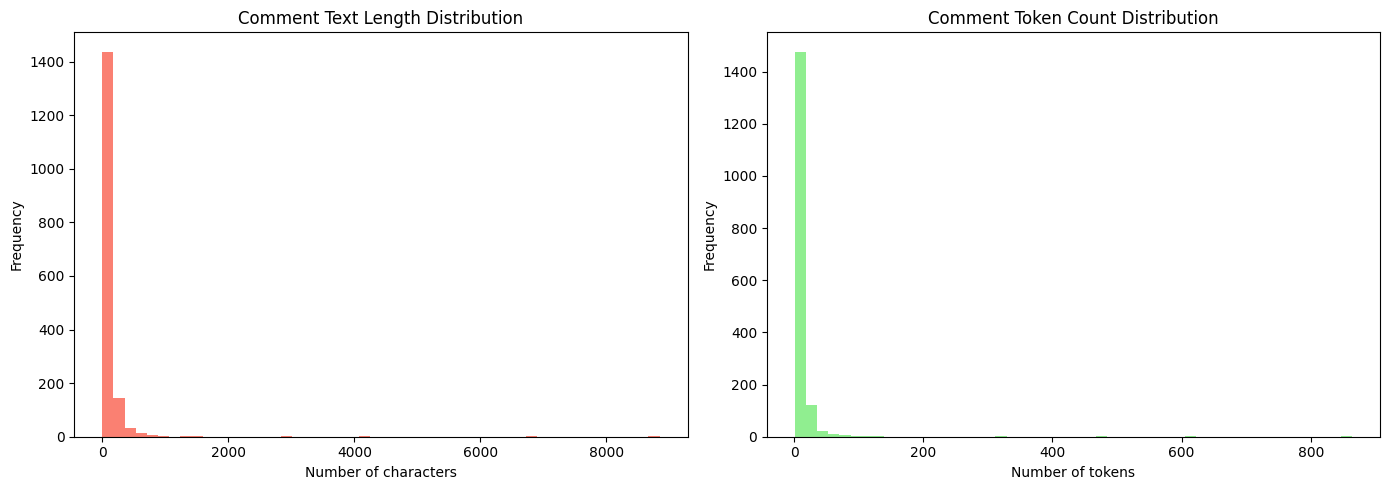

/tmp/ipython-input-1818071595.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Comment Text', 'Tokens'])


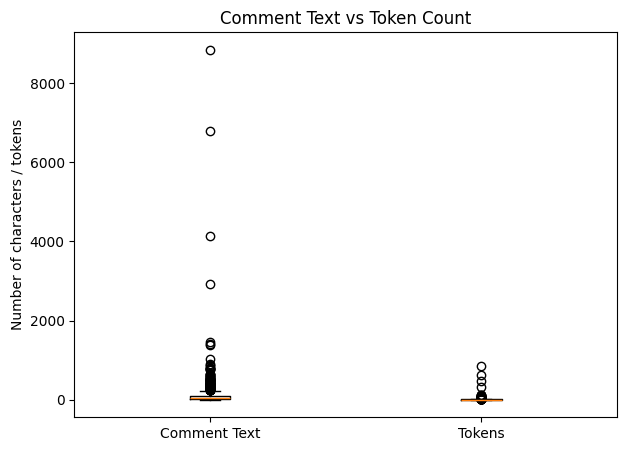

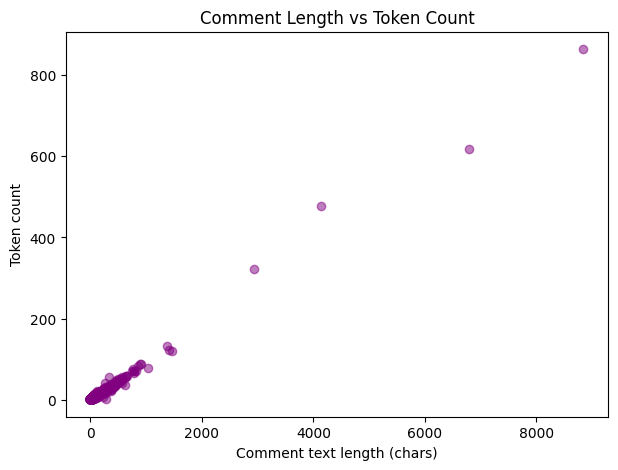

/tmp/ipython-input-1818071595.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(users), y=list(counts), palette='coolwarm')


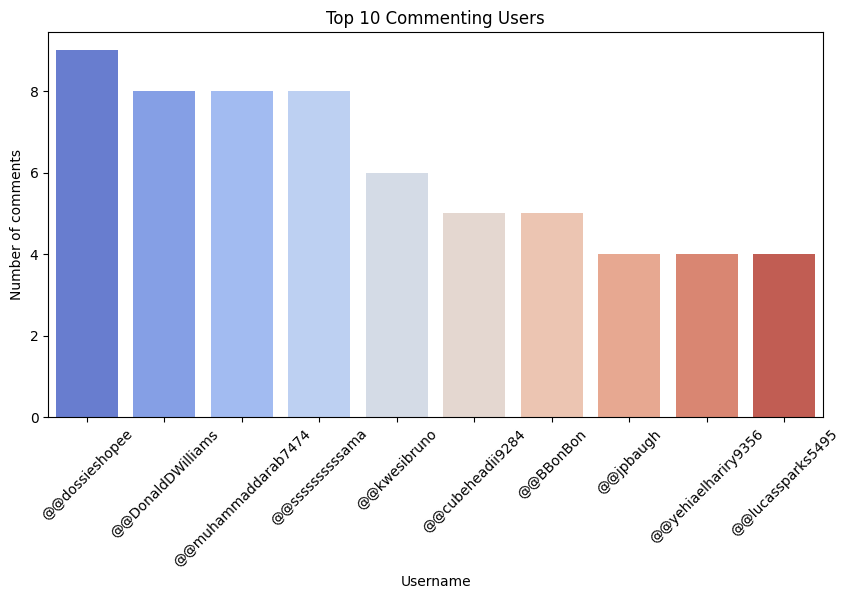

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Load CSV file
comments_file = "/content/drive/MyDrive/477Project/youtube_comments.csv"
comments_df = pd.read_csv(comments_file)

# -------------------------------
# 1️⃣ Calculate lengths
# -------------------------------
comments_text = comments_df['comment_text'].astype(str)
cleaned_tokens = comments_df['cleaned_tokens'].astype(str)
usernames = comments_df['username'].astype(str)

comments_length = comments_text.str.len()
tokens_length = cleaned_tokens.str.split().apply(len)
username_length = usernames.str.len()

# -------------------------------
# 2️⃣ Histograms
# -------------------------------
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.hist(comments_length, bins=50, color='salmon')
plt.title('Comment Text Length Distribution')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(tokens_length, bins=50, color='lightgreen')
plt.title('Comment Token Count Distribution')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# -------------------------------
# 3️⃣ Boxplots
# -------------------------------
plt.figure(figsize=(7,5))
data = [comments_length, tokens_length]
plt.boxplot(data, labels=['Comment Text', 'Tokens'])
plt.title('Comment Text vs Token Count')
plt.ylabel('Number of characters / tokens')
plt.show()

# -------------------------------
# 4️⃣ Scatter plot: text length vs token count
# -------------------------------
plt.figure(figsize=(7,5))
plt.scatter(comments_length, tokens_length, alpha=0.5, color='purple')
plt.title('Comment Length vs Token Count')
plt.xlabel('Comment text length (chars)')
plt.ylabel('Token count')
plt.show()

# -------------------------------
# 5️⃣ Top 10 usernames by comment count
# -------------------------------
top_users = Counter(usernames).most_common(10)
users, counts = zip(*top_users)

plt.figure(figsize=(10,5))
sns.barplot(x=list(users), y=list(counts), palette='coolwarm')
plt.title('Top 10 Commenting Users')
plt.xlabel('Username')
plt.ylabel('Number of comments')
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-3692976900.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tokens), y=list(token_freqs), palette='viridis')


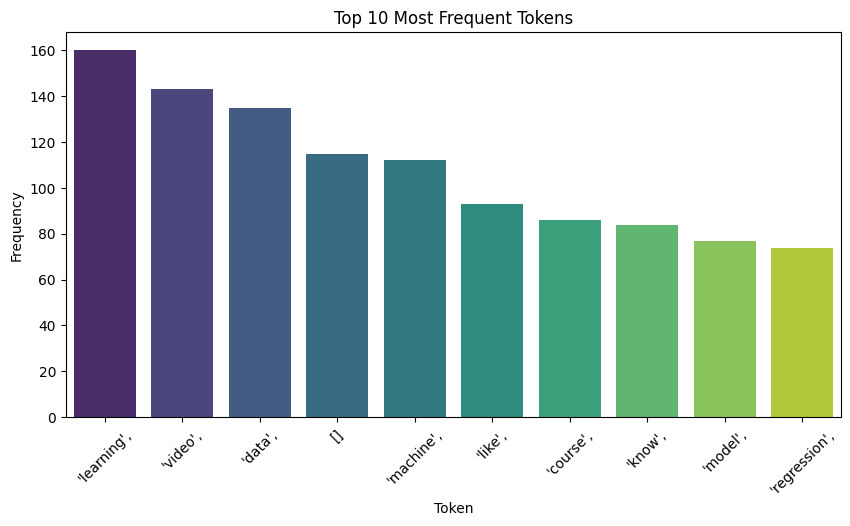

In [ ]:
# Extract cleaned tokens and flatten all tokens into a list
cleaned_tokens = comments_df['cleaned_tokens'].astype(str)
all_tokens = cleaned_tokens.str.split().sum()  # flatten all tokens

# Count token frequencies
token_counts = Counter(all_tokens)
top_tokens = token_counts.most_common(10)
tokens, token_freqs = zip(*top_tokens)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=list(tokens), y=list(token_freqs), palette='viridis')
plt.title('Top 10 Most Frequent Tokens')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-3317943575.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(token_freqs), y=list(tokens), palette='viridis')


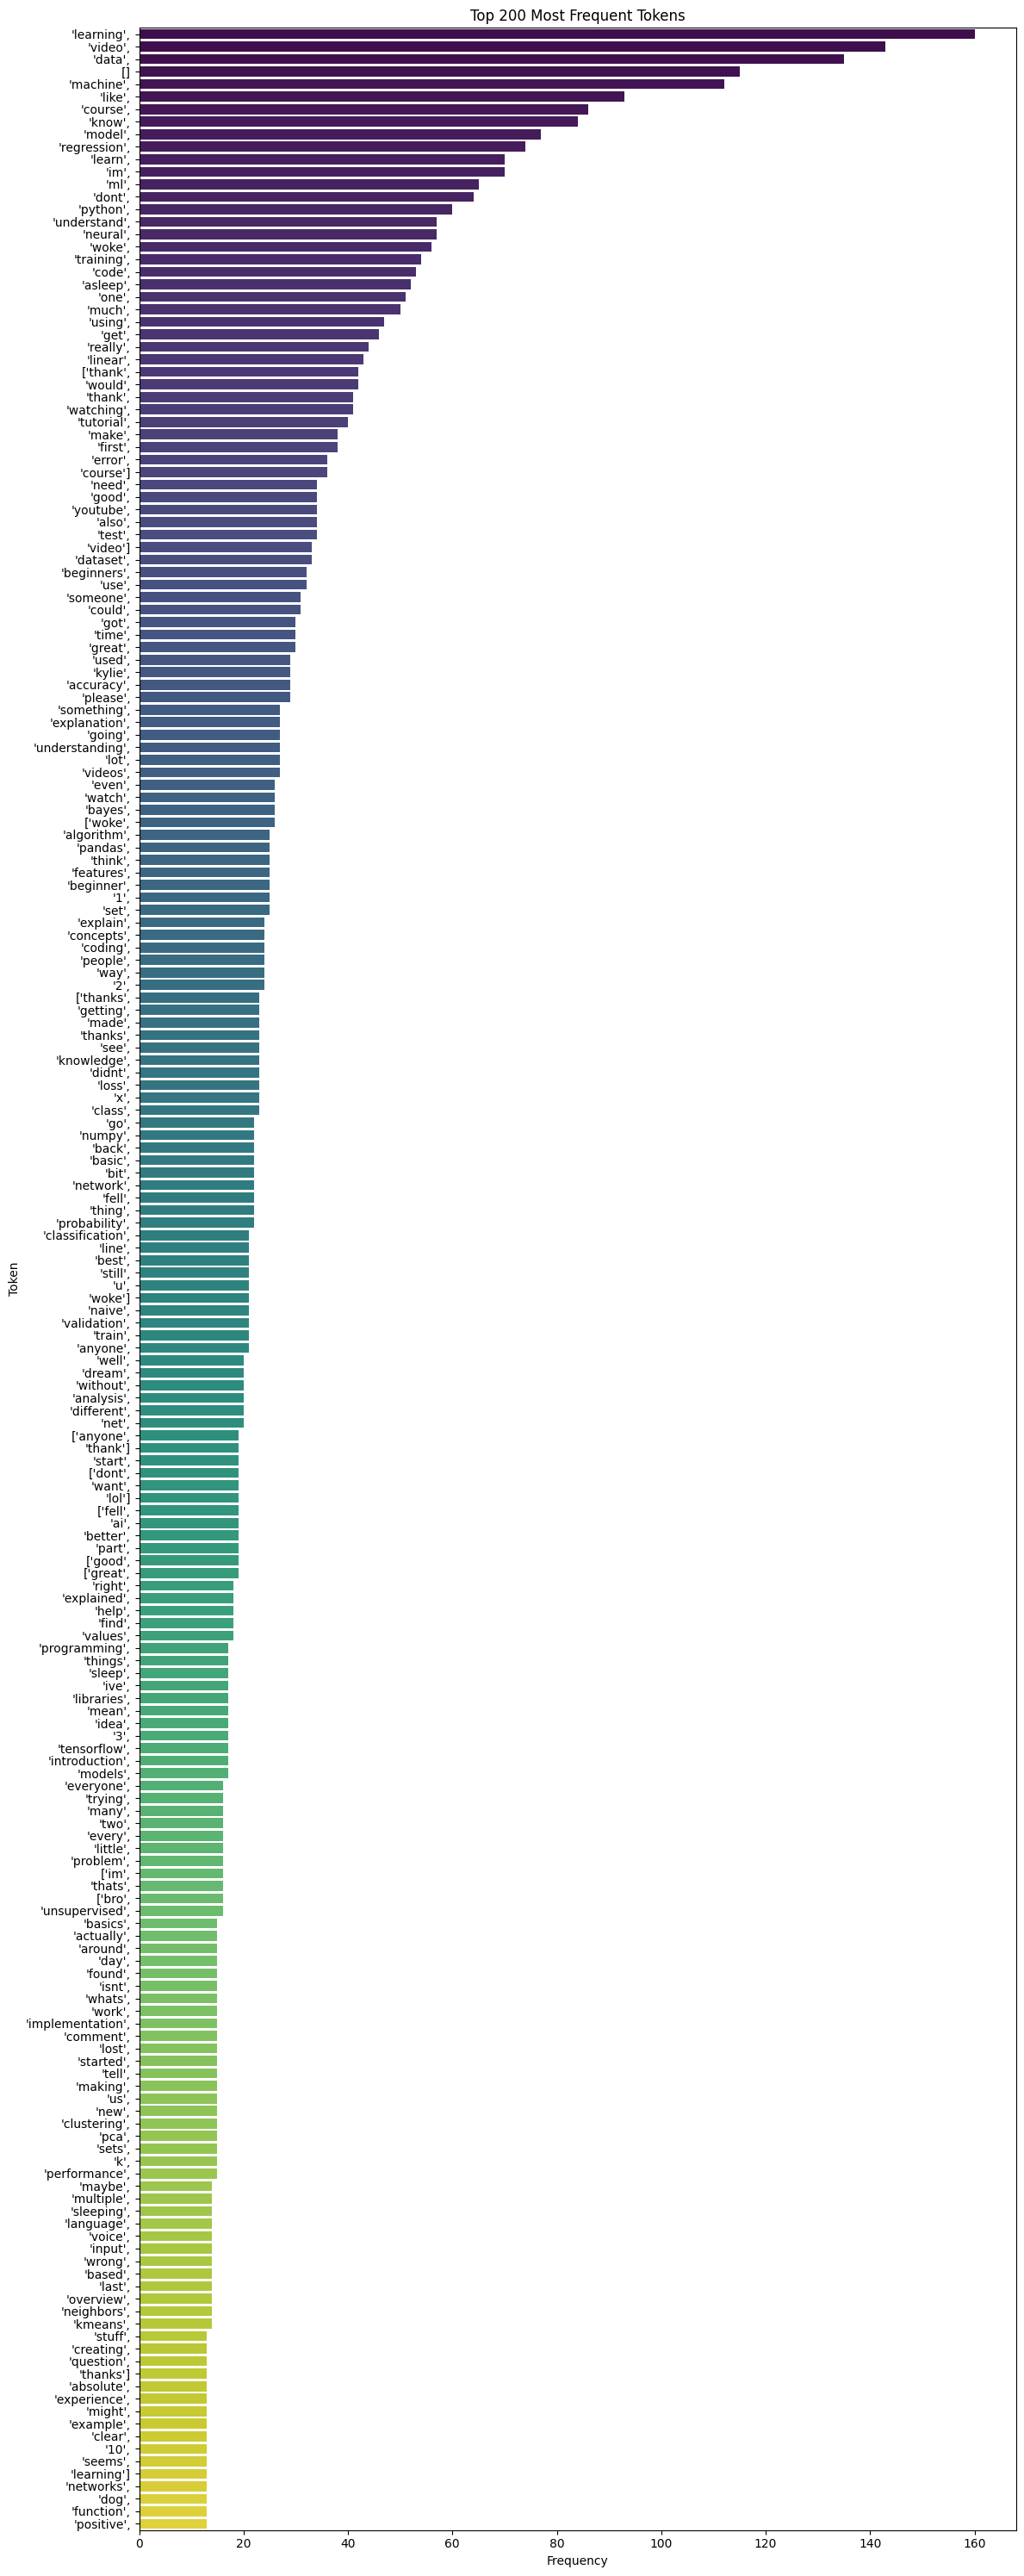

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV file
comments_file = "/content/drive/MyDrive/477Project/youtube_comments.csv"
comments_df = pd.read_csv(comments_file)

# Extract cleaned tokens and flatten all tokens into a list
cleaned_tokens = comments_df['cleaned_tokens'].astype(str)
all_tokens = cleaned_tokens.str.split().sum()  # flatten all tokens

# Count token frequencies
token_counts = Counter(all_tokens)
top_tokens = token_counts.most_common(200)  # pick top 200 tokens
tokens, token_freqs = zip(*top_tokens)

# Plot horizontal bar chart
plt.figure(figsize=(12, 30))
sns.barplot(x=list(token_freqs), y=list(tokens), palette='viridis')
plt.title('Top 200 Most Frequent Tokens')
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.tight_layout()
plt.show()


Save Cleaned Comment

In [ ]:
import pandas as pd
import ast

# Load CSV file
comments_file = "/content/drive/MyDrive/477Project/youtube_comments.csv"
comments_df = pd.read_csv(comments_file)

# -------------------------------
# 1️⃣ Clean 'cleaned_tokens' column
# Convert string representation of list to actual list
comments_df['cleaned_tokens'] = comments_df['cleaned_tokens'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# -------------------------------
# 2️⃣ Clean 'comment_text' column
comments_df['comment_text'] = comments_df['comment_text'].astype(str).str.lower().str.strip()

# -------------------------------
# 3️⃣ Clean 'username' column
comments_df['username'] = comments_df['username'].astype(str).str.replace('@@', '', regex=False).str.strip()

# -------------------------------
# 4️⃣ Remove duplicates and empty comments
comments_df = comments_df.drop_duplicates(subset=['comment_text'])
comments_df = comments_df[comments_df['comment_text'].str.strip() != ""]

# -------------------------------
# 5️⃣ Reset index
comments_df = comments_df.reset_index(drop=True)

# -------------------------------
# 6️⃣ Save cleaned version
cleaned_file = "/content/drive/MyDrive/477Project/youtube_comments_cleaned.csv"
comments_df.to_csv(cleaned_file, index=False)

print(f"Cleaned comments saved to: {cleaned_file}")


Cleaned comments saved to: /content/drive/MyDrive/477Project/youtube_comments_cleaned.csv


Clean Caption

In [ ]:
import pandas as pd

# Load captions CSV
captions_file = "/content/drive/MyDrive/477Project/captions.csv"
captions_df = pd.read_csv(captions_file)

# -------------------------------
# Clean 'cleaned_tokens' column safely
def parse_tokens(x):
    if pd.isna(x) or x.strip() == "":
        return []
    x = x.strip()
    if x.startswith("[") and x.endswith("]"):
        try:
            import ast
            return ast.literal_eval(x)
        except:
            # fallback: remove brackets and split
            return x[1:-1].replace("'", "").split(",")
    else:
        # if it's plain text, just split by spaces
        return x.split()

captions_df['cleaned_tokens'] = captions_df['cleaned_tokens'].apply(parse_tokens)

# -------------------------------
# Clean 'caption_sentence' column
captions_df['caption_sentence'] = captions_df['caption_sentence'].astype(str).str.lower().str.strip()

# -------------------------------
# Remove duplicates and empty captions
captions_df = captions_df.drop_duplicates(subset=['caption_sentence'])
captions_df = captions_df[captions_df['caption_sentence'].str.strip() != ""]

# -------------------------------
# Reset index
captions_df = captions_df.reset_index(drop=True)

# -------------------------------
# Save cleaned captions
cleaned_captions_file = "/content/drive/MyDrive/477Project/captions_cleaned.csv"
captions_df.to_csv(cleaned_captions_file, index=False)

print(f"Cleaned captions saved to: {cleaned_captions_file}")


Cleaned captions saved to: /content/drive/MyDrive/477Project/captions_cleaned.csv


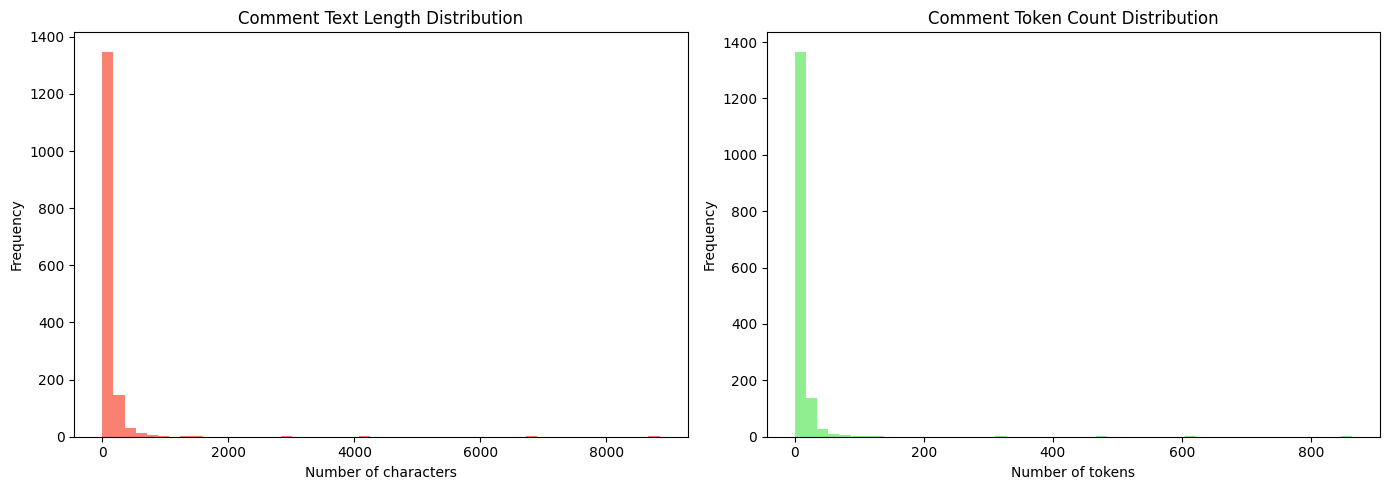

/tmp/ipython-input-3608198550.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([comments_length, tokens_length], labels=['Comment Text', 'Tokens'])


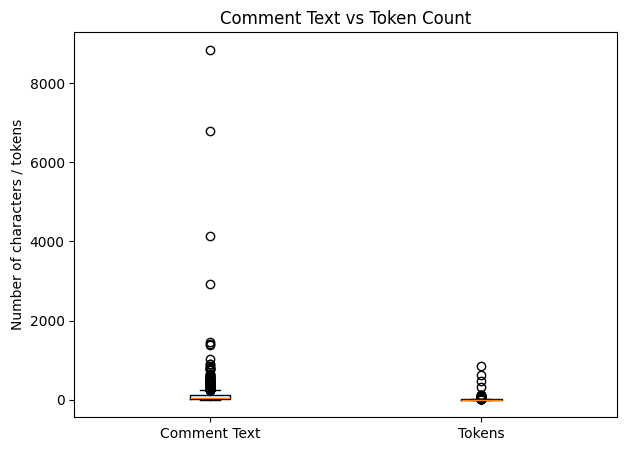

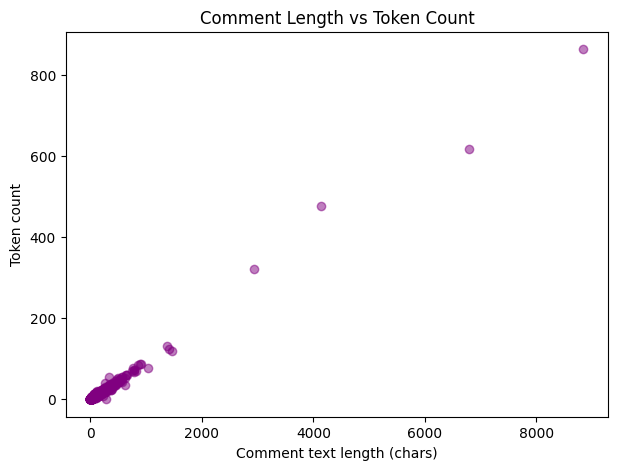

/tmp/ipython-input-3608198550.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(users), y=list(counts), palette='coolwarm')


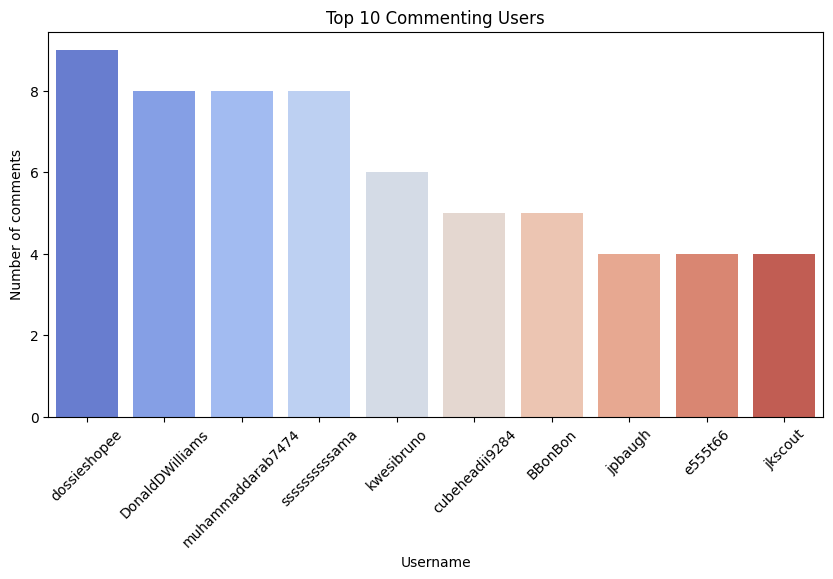

/tmp/ipython-input-3608198550.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(token_freqs), y=list(tokens), palette='viridis')


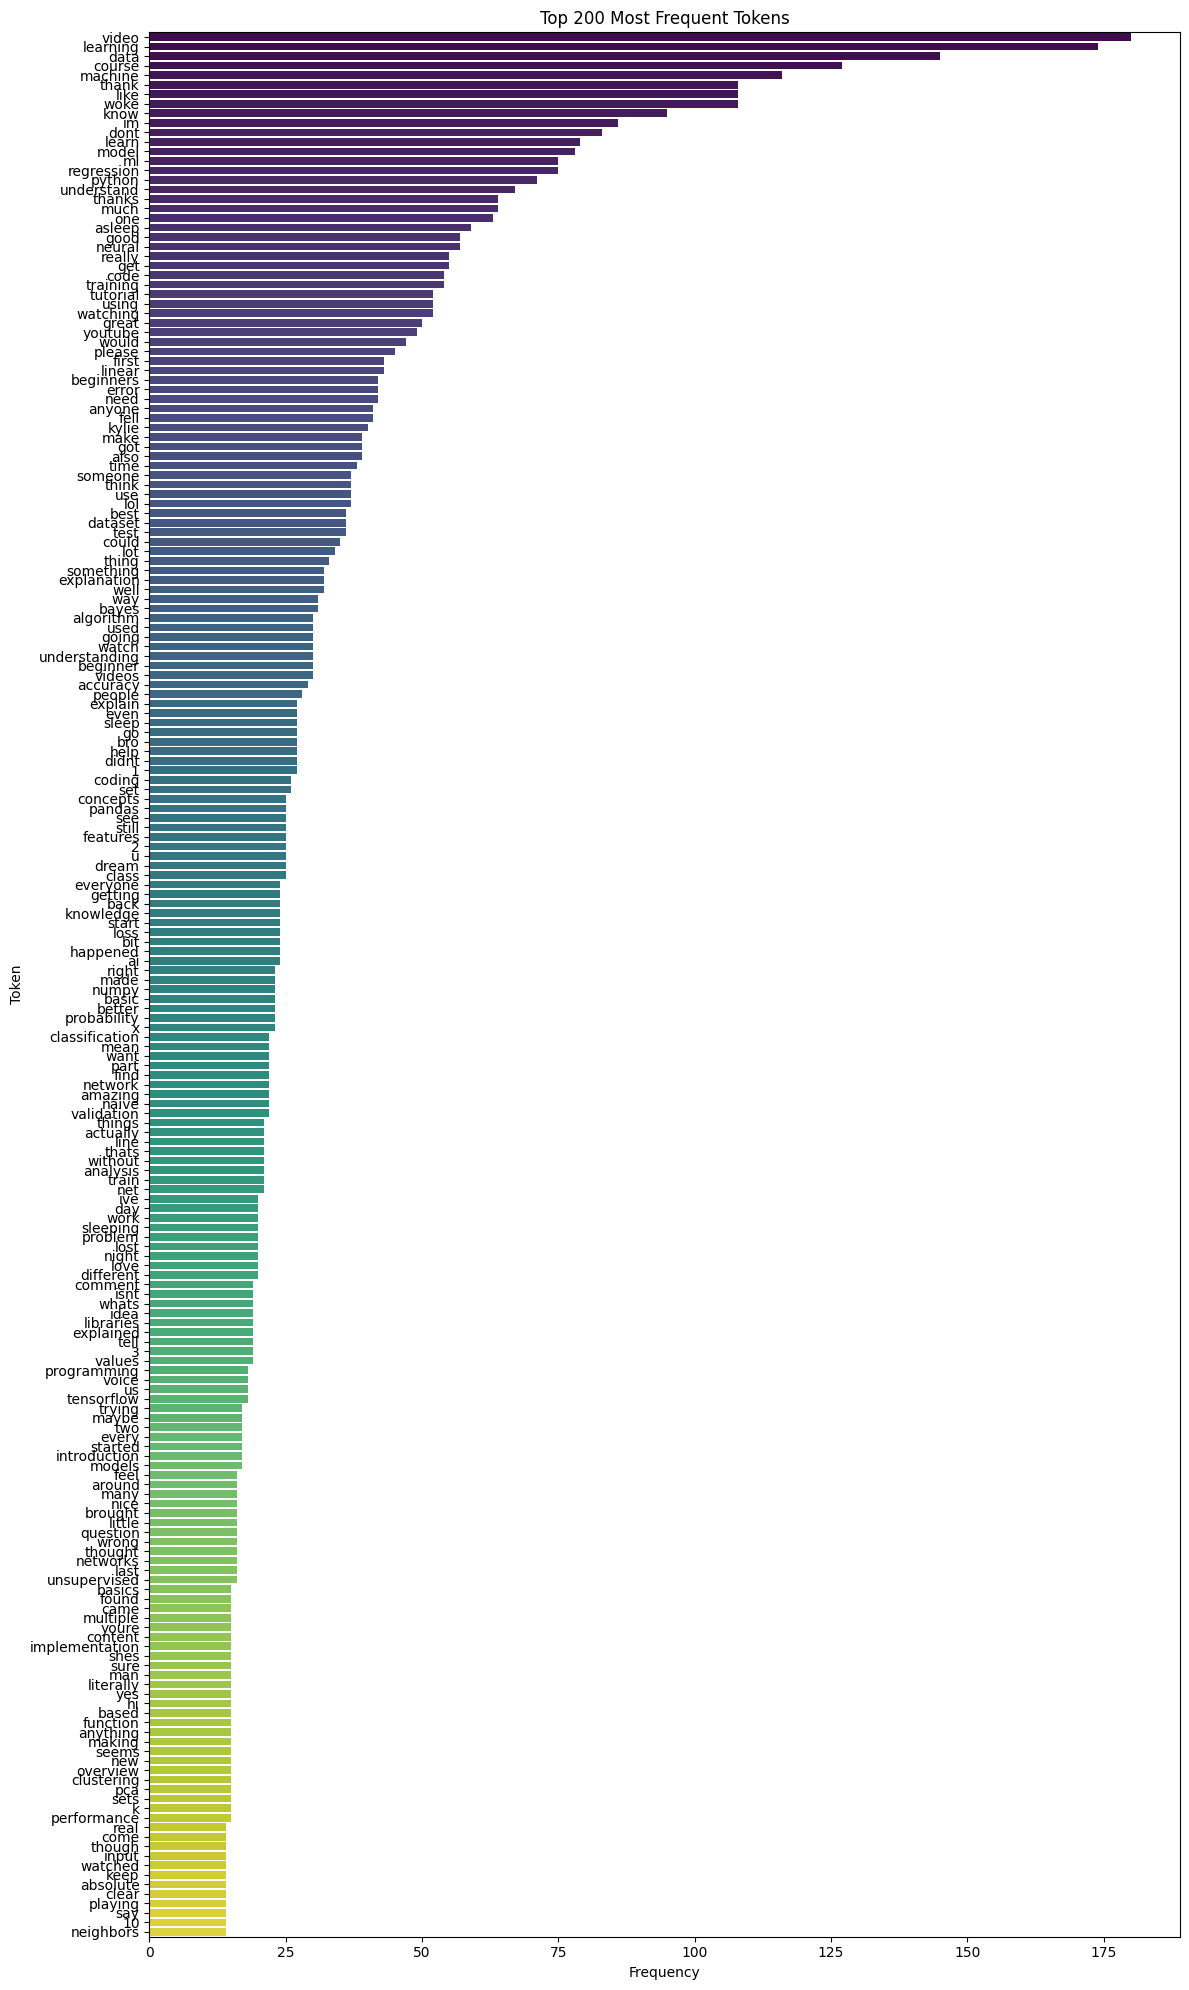

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load cleaned comments CSV
comments_file = "/content/drive/MyDrive/477Project/youtube_comments_cleaned.csv"
comments_df = pd.read_csv(comments_file)

# Ensure 'cleaned_tokens' column is actual lists
import ast
comments_df['cleaned_tokens'] = comments_df['cleaned_tokens'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# -------------------------------
# 1️⃣ Comment text length
comments_text = comments_df['comment_text'].astype(str)
comments_length = comments_text.str.len()

# 2️⃣ Token count
tokens_length = comments_df['cleaned_tokens'].apply(len)

# 3️⃣ Histogram of comment text lengths and token counts
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(comments_length, bins=50, color='salmon')
plt.title('Comment Text Length Distribution')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(tokens_length, bins=50, color='lightgreen')
plt.title('Comment Token Count Distribution')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# -------------------------------
# 4️⃣ Boxplot: text vs token length
plt.figure(figsize=(7,5))
plt.boxplot([comments_length, tokens_length], labels=['Comment Text', 'Tokens'])
plt.title('Comment Text vs Token Count')
plt.ylabel('Number of characters / tokens')
plt.show()

# -------------------------------
# 5️⃣ Scatter plot: text length vs token count
plt.figure(figsize=(7,5))
plt.scatter(comments_length, tokens_length, alpha=0.5, color='purple')
plt.title('Comment Length vs Token Count')
plt.xlabel('Comment text length (chars)')
plt.ylabel('Token count')
plt.show()

# -------------------------------
# 6️⃣ Top 10 usernames by comment count
top_users = Counter(comments_df['username']).most_common(10)
users, counts = zip(*top_users)

plt.figure(figsize=(10,5))
sns.barplot(x=list(users), y=list(counts), palette='coolwarm')
plt.title('Top 10 Commenting Users')
plt.xlabel('Username')
plt.ylabel('Number of comments')
plt.xticks(rotation=45)
plt.show()

# -------------------------------
# 7️⃣ Top 200 tokens by frequency
all_tokens = [token for sublist in comments_df['cleaned_tokens'] for token in sublist]
token_counts = Counter(all_tokens)
top_tokens = token_counts.most_common(200)
tokens, token_freqs = zip(*top_tokens)

plt.figure(figsize=(12,20))
sns.barplot(x=list(token_freqs), y=list(tokens), palette='viridis')
plt.title('Top 200 Most Frequent Tokens')
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                        comment_text  compound sentiment
0  this is definitely not a tutorial for "everyon...    0.4019  Positive
1  yesterday i click on a video called 'learning ...    0.7779  Positive
2  thanks for an amazingly simplified approach to...    0.4404  Positive
3  i've been trying to learn ml for quite awhile ...    0.9183  Positive
4  no fancy words, just simple english and the ri...    0.3818  Positive


/tmp/ipython-input-1179875852.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=comments_df, palette='coolwarm')


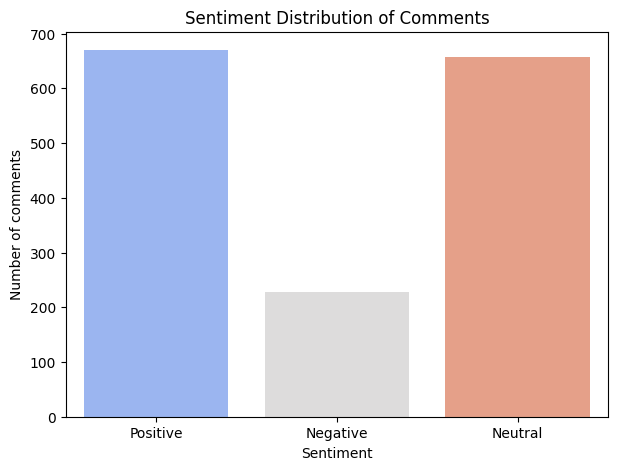

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Download VADER lexicon (if not already)
nltk.download('vader_lexicon')

# Load cleaned comments
comments_file = "/content/drive/MyDrive/477Project/youtube_comments_cleaned.csv"
comments_df = pd.read_csv(comments_file)

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
comments_df['sentiment_scores'] = comments_df['comment_text'].apply(lambda x: sia.polarity_scores(x))

# Extract compound score for overall sentiment
comments_df['compound'] = comments_df['sentiment_scores'].apply(lambda x: x['compound'])

# Classify sentiment
def sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

comments_df['sentiment'] = comments_df['compound'].apply(sentiment_label)

# -------------------------------
# View sample
print(comments_df[['comment_text', 'compound', 'sentiment']].head())

# -------------------------------
# Plot sentiment distribution
plt.figure(figsize=(7,5))
sns.countplot(x='sentiment', data=comments_df, palette='coolwarm')
plt.title('Sentiment Distribution of Comments')
plt.xlabel('Sentiment')
plt.ylabel('Number of comments')
plt.show()


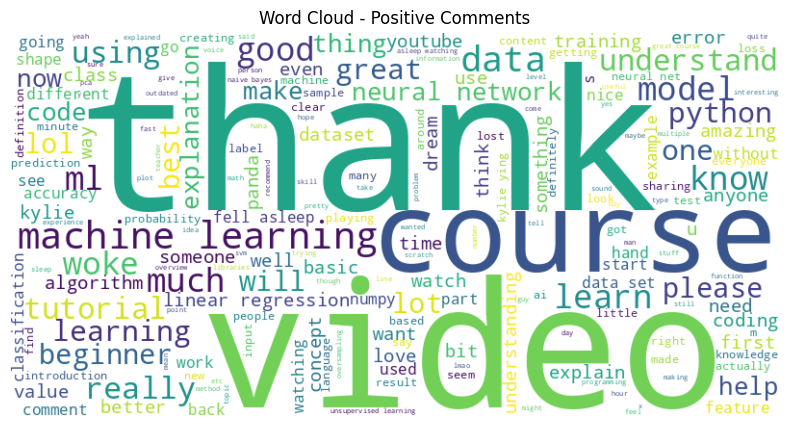

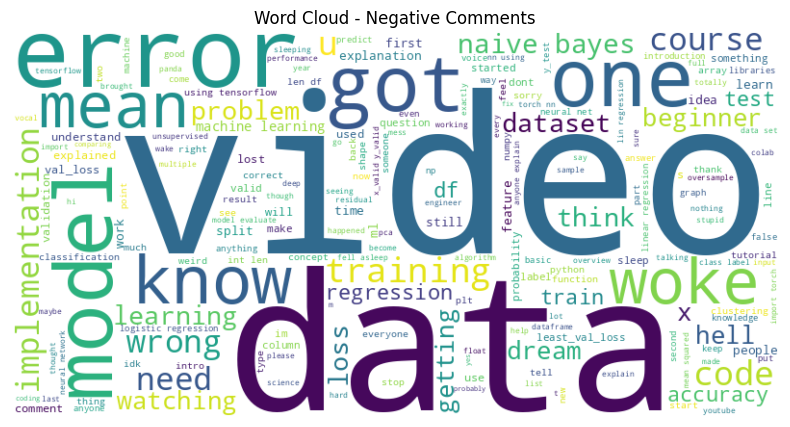

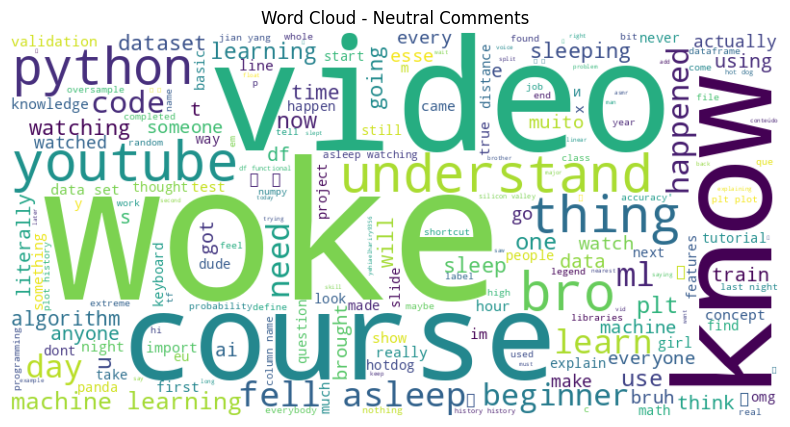

In [ ]:
from wordcloud import WordCloud

for sentiment in ['Positive', 'Negative', 'Neutral']:
    text = " ".join(comments_df[comments_df['sentiment'] == sentiment]['comment_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sentiment} Comments')
    plt.show()


nltk


In [ ]:
pip install pandas nltk matplotlib

In [ ]:
!python -c "import nltk; nltk.download('vader_lexicon')"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import pandas as pd

# Load the separate CSV files
df_captions = pd.read_csv("/content/drive/MyDrive/477Project/captions_cleaned.csv")
df_comments = pd.read_csv("/content/drive/MyDrive/477Project/youtube_comments_cleaned.csv")

print("Columns in captions.csv:", df_captions.columns.tolist())
print("Columns in comments.csv:", df_comments.columns.tolist())

Columns in captions.csv: ['start_time', 'end_time', 'caption_sentence', 'cleaned_tokens']
Columns in comments.csv: ['username', 'timestamp_text', 'comment_text', 'cleaned_tokens']


Sentiment analysis complete! Check your Colab file browser for the new CSV files and image outputs.


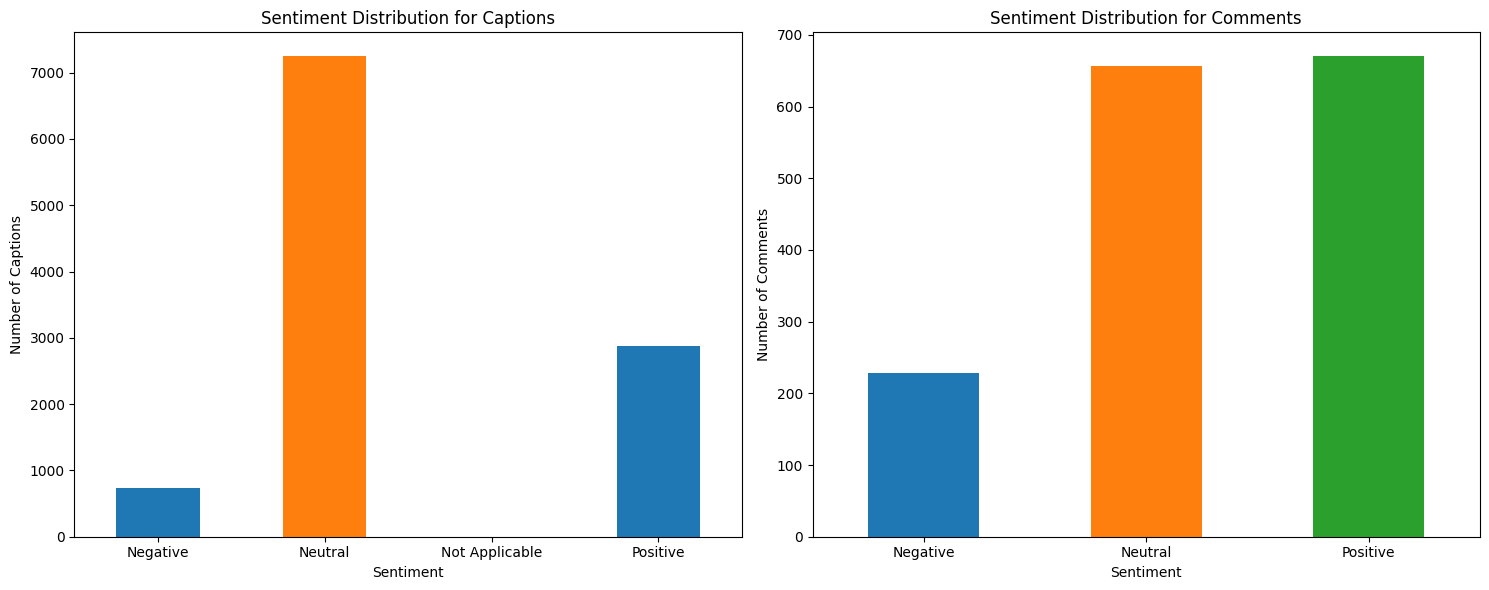

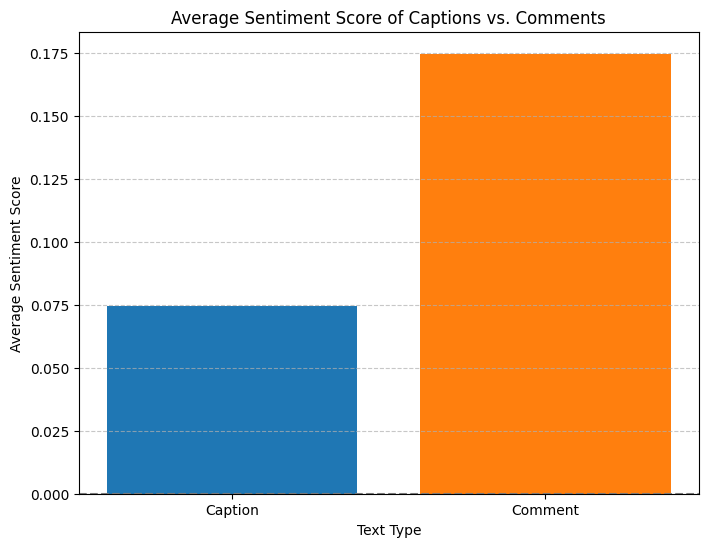

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score and label
def get_sentiment(text):
    if not isinstance(text, str):
        return None, "Not Applicable"
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        label = "Positive"
    elif score <= -0.05:
        label = "Negative"
    else:
        label = "Neutral"
    return score, label

# Perform sentiment analysis using the correct column names
df_captions['sentiment_score'], df_captions['sentiment'] = zip(*df_captions['caption_sentence'].apply(get_sentiment))
df_comments['sentiment_score'], df_comments['sentiment'] = zip(*df_comments['comment_text'].apply(get_sentiment))

# Save the updated DataFrames to new CSV files in your Colab session
df_captions.to_csv("caption_sentiment_results.csv", index=False)
df_comments.to_csv("comment_sentiment_results.csv", index=False)

# Analyze the sentiment distribution for captions and comments
caption_sentiment_counts = df_captions['sentiment'].value_counts()
comment_sentiment_counts = df_comments['sentiment'].value_counts()

# Create subplots for the bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sentiment distribution for captions
caption_sentiment_counts.sort_index().plot(kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_title('Sentiment Distribution for Captions')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Number of Captions')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Plot sentiment distribution for comments
comment_sentiment_counts.sort_index().plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('Sentiment Distribution for Comments')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Number of Comments')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig("sentiment_distribution.png")

# Calculate average sentiment scores
avg_caption_score = df_captions['sentiment_score'].mean()
avg_comment_score = df_comments['sentiment_score'].mean()

# Create a bar chart for average sentiment scores
avg_scores = pd.DataFrame({
    'Source': ['Caption', 'Comment'],
    'Average Sentiment Score': [avg_caption_score, avg_comment_score]
})

plt.figure(figsize=(8, 6))
plt.bar(avg_scores['Source'], avg_scores['Average Sentiment Score'], color=['#1f77b4', '#ff7f0e'])
plt.title('Average Sentiment Score of Captions vs. Comments')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Text Type')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("average_sentiment_comparison.png")

print("Sentiment analysis complete! Check your Colab file browser for the new CSV files and image outputs.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------- 1. LOAD DATA ----------------------
captions = pd.read_csv("/content/drive/MyDrive/477Project/captions_with_sentiment.csv")
comments = pd.read_csv("/content/drive/MyDrive/477Project/comments_with_sentiment.csv")

In [ ]:
comments.head()

,username,timestamp_text,comment_text,cleaned_tokens,processed_text,sentiment
0,adelinad5102,3 months ago,"this is definitely not a tutorial for ""everyon...","['definitely', 'tutorial', 'everyone', 'beginn...",definitely tutorial everyone beginners beware ...,positive
1,auliamardhatillah2240,2 years ago,yesterday i click on a video called 'learning ...,"['yesterday', 'click', 'video', 'called', 'lea...",yesterday click video called learning phyton b...,positive
2,risebyliftingothers,2 years ago (edited),thanks for an amazingly simplified approach to...,"['thanks', 'amazingly', 'simplified', 'approac...",thanks amazingly simplified approach ml,positive
3,limwei2634,2 years ago,i've been trying to learn ml for quite awhile ...,"['ive', 'trying', 'learn', 'ml', 'quite', 'awh...",ive trying learn ml quite awhile could never r...,positive
4,nancykataria08,4 months ago,"no fancy words, just simple english and the ri...","['fancy', 'words', 'simple', 'english', 'right...",fancy words simple english right pace explain ...,positive


In [ ]:
import pandas as pd

# Make sure all values are strings (replace NaN with empty string)
comments['processed_text'] = comments['processed_text'].fillna('').astype(str)

# Calculate length of each row
comments['text_length'] = comments['processed_text'].apply(len)

# Compute median length
median_length = comments['text_length'].median()

print("Median length of processed_text:", median_length)


Median length of processed_text: 33.0


In [ ]:
captions.head()

,start_time,end_time,caption_sentence,cleaned_tokens,processed_text,sentiment
0,00:00:00.000,00:00:01.590,NaN,[],NaN,neutral
1,00:00:01.590,00:00:01.600,kylie ying has worked at many,"['kylie', 'ying', 'has', 'worked', 'at', 'many']",kylie ying has worked at many,neutral
2,00:00:01.600,00:00:04.870,kylie ying has worked at many interesting plac...,"['kylie', 'ying', 'has', 'worked', 'at', 'many...",kylie ying has worked at many interesting plac...,positive
3,00:00:04.870,00:00:04.880,interesting places such as mit cern and,"['interesting', 'places', 'such', 'as', 'mit',...",interesting places such as mit cern and,positive
4,00:00:04.880,00:00:07.030,interesting places such as mit cern and free c...,"['interesting', 'places', 'such', 'as', 'mit',...",interesting places such as mit cern and free c...,positive


In [ ]:
import pandas as pd

# Make sure all values are strings (replace NaN with empty string)
captions['caption_sentence'] = captions['caption_sentence'].fillna('').astype(str)

# Calculate length of each row and sum them
total_length = captions['caption_sentence'].apply(len).sum()

print("Total length of all captions:", total_length)


Total length of all captions: 432729


In [ ]:
import pandas as pd
import re

# Ensure all values are strings
comments['comment_text'] = comments['comment_text'].fillna('').astype(str)

# Extended regex pattern including common emojis and reactions
emoji_pattern = re.compile(
    "["

    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Misc symbols & pictographs
    "\U0001F680-\U0001F6FF"  # Transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # Flags
    "\U00002700-\U000027BF"  # Dingbats
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols & Pictographs
    "\U00002600-\U000026FF"  # Misc symbols
    "\U0001FA70-\U0001FAFF"  # Symbols & Pictographs Extended-A
    "\U000025A0-\U000025FF"  # Geometric Shapes
    "\U00002300-\U000023FF"  # Misc Technical

    # Common reactions/emojis
    "\U0001F44D"  # 👍 Like
    "\U0001F44E"  # 👎 Dislike
    "\U0001F44F"  # 👏 Clap
    "\U0001F91D"  # 🤝 Handshake
    "]+", flags=re.UNICODE
)

# Function to count emojis/reactions in text
def count_emojis(text):
    return len(emoji_pattern.findall(text))

# Total characters
total_chars = comments['comment_text'].apply(len).sum()

# Total emojis/reactions
total_emojis = comments['comment_text'].apply(count_emojis).sum()

# Emoji/reaction percentage
emoji_percentage = (total_emojis / total_chars) * 100 if total_chars > 0 else 0

print(f"Emoji/reaction percentage in all comments: {emoji_percentage:.2f}%")


Emoji/reaction percentage in all comments: 0.25%


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure all values are strings
comments['comment_text'] = comments['comment_text'].fillna('').astype(str)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # remove common words, keep top 1000 features

# Fit and transform comment_text
tfidf_matrix = vectorizer.fit_transform(comments['comment_text'])

# Get feature names (words)
terms = vectorizer.get_feature_names_out()

# Convert to DataFrame for easy viewing
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

print("TF-IDF DataFrame shape:", tfidf_df.shape)
print(tfidf_df.head())


TF-IDF DataFrame shape: (1555, 1000)
    00  000   01   02   03   04   05   06   07   08  ...  yesterday  ying  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0000   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.2698   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0000   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0000   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0000   0.0   

   ylabel  young  youtu   youtube   yt   за  понятно   ဘယ  
0     0.0    0.0    0.0  0.000000  0.0  0.0      0.0  0.0  
1     0.0    0.0    0.0  0.182573  0.0  0.0      0.0  0.0  
2     0.0    0.0    0.0  0.000000  0.0  0.0      0.0  0.0  
3     0.0    0.0    0.0  0.000000  0.0  0.0      0.0  0.0  
4     0.0    0.0    0.0  0.000000  0.0  0.0      0.0  0.0  

[5 rows x 1000 columns]


In [ ]:
# Average TF-IDF score of each term across all comments
avg_tfidf = tfidf_df.mean(axis=0)

# Sort descending and get top 10
top_10_terms = avg_tfidf.sort_values(ascending=False).head(10)

print("Top 10 TF-IDF Terms (all comments):")
print(top_10_terms)


Top 10 TF-IDF Terms (all comments):
video       0.028205
woke        0.026746
thank       0.026538
just        0.023992
course      0.023286
learning    0.018882
thanks      0.017426
like        0.017069
know        0.015711
machine     0.014825
dtype: float64


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from collections import Counter
from sklearn.decomposition import PCA

# Ensure all text is string
comments['comment_text'] = comments['comment_text'].fillna('').astype(str)

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(comments['comment_text'])
terms = vectorizer.get_feature_names_out()

# KMeans with 20 clusters
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
comments['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Top words per cluster
top_words = {}
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    top_words[i] = [terms[ind] for ind in order_centroids[i, :10]]  # top 10 words


In [ ]:
cluster_summary = pd.DataFrame({
    'Cluster': range(n_clusters),
    'Top words': [', '.join(top_words[i]) for i in range(n_clusters)],
    'Short label': [''] * n_clusters,  # fill manually
    'Notes': [''] * n_clusters         # optional notes
})

print(cluster_summary)


    Cluster                                          Top words Short label  \
0         0  did, sure, know, shortcut, theory, happen, pro...               
1         1  panda, start, numpy, learn, course, falling, f...               
2         2  file, possible, need, course, finally, figure,...               
3         3  wanted, sorry, man, voice, class, problem, exp...               
4         4  residuals, determine, running, yesterday, read...               
5         5  study, use, really, learning, fell, feel, feat...               
6         6  video, thank, woke, just, course, learning, th...               
7         7  good, course, ml, night, basic, beginners, mor...               
8         8  tooo, dude, happened, lol, figure, felt, fell,...               
9         9  100, like, familiar, family, fantastic, far, f...               
10       10  using, file, figure, felt, fell, feel, feature...               
11       11  distance, middle, qualitative, especially, que...  

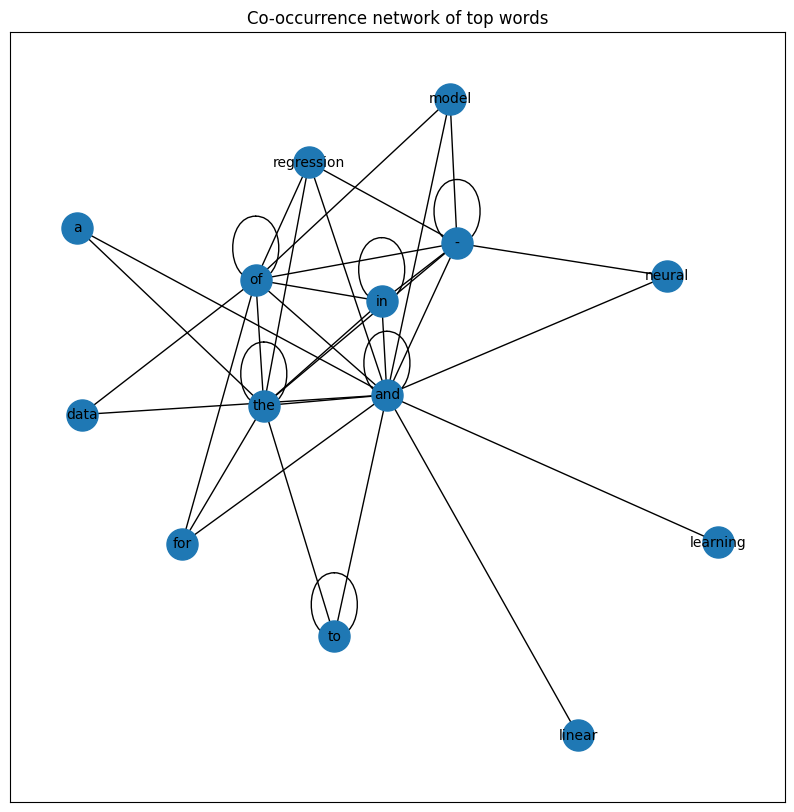

In [ ]:
edges = []
for tokens in comments['comment_text'].str.lower().str.split():
    if len(tokens) > 1:
        edges.extend(combinations(tokens, 2))

edge_counts = Counter(edges)

G = nx.Graph()
for (w1, w2), weight in edge_counts.most_common(50):
    G.add_edge(w1, w2, weight=weight)

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx(G, pos, with_labels=True, node_size=500, font_size=10)
plt.title("Co-occurrence network of top words")
plt.show()


In [ ]:
# Loop through each cluster
for cluster_num in range(1):
    print(f"\n--- Cluster {cluster_num} ---")
    # Select comments in this cluster
    cluster_comments = comments[comments['cluster'] == cluster_num]['comment_text']
    # Print each comment
    for idx, comment in enumerate(cluster_comments, 1):
        print(f"{idx}. {comment}")



--- Cluster 0 ---
1. @monotheist_me  sure did!
2. that one water droplet did the job for me
3. why did fhis happen to me too
4. i was watching a one piece theory video...how did i end up here
5. impressive comments. did you encounter a problem with data links 🔗? i am, how can i navigate it please?
6. ​
starting today 44:49 not sure what i learnt but i did learn something
7. did a refresher on ml as it's been a while... kylie rocks!  delivered with the right amount of theory combined with examples and importantly, clarity!  top marks!!!!!
8. bruh what how did u know
9. did you find this anywhere something useful
10. what model did you used to predict this?
absolutely correct😮
11. like how did it go from rain sounds to learning tech 😭😭😭
12. i am getting the same error, how did u rectify it?
13. i did enjoy your course! thanks for sharing!
14. also, where did she get that tablet from, it works so cool! ;)
15. why did your first 3 imports work for you?
16. where did you get imports?
17. a

In [ ]:
import pandas as pd
from collections import Counter

# Load your captions CSV
captions = pd.read_csv("/content/drive/MyDrive/477Project/captions_with_sentiment.csv")

# Fill NaN and ensure text is string
captions['processed_text'] = captions['processed_text'].fillna('').astype(str)

# Combine all captions into one text
full_text = ' '.join(captions['processed_text'].str.lower())

# Define themes and keywords
themes_keywords = {
    'Learning/Tutorial': ['learn', 'tutorial', 'course', 'lesson', 'educational', 'training', 'ml', 'data', 'python'],
    'Timing/Upload Feedback': ['upload', 'video', 'time', 'schedule', 'release', 'post', 'content'],
    'Lifestyle/Travel': ['travel', 'vlog', 'trip', 'lifestyle', 'adventure', 'food', 'journey', 'tour'],
    'Entertainment/Movies': ['movie', 'film', 'song', 'music', 'entertainment', 'video'],
    'App/Software Review': ['app', 'software', 'review', 'demo', 'platform', 'tool'],
}

# Count keyword occurrences per theme
theme_counter = Counter()
for theme, keywords in themes_keywords.items():
    count = sum(full_text.count(k) for k in keywords)
    if count > 0:
        theme_counter[theme] = count

# Select the main theme
if theme_counter:
    main_theme = theme_counter.most_common(1)[0][0]
else:
    main_theme = 'Other/Uncategorized'

print("Main theme of the video:", main_theme)


Main theme of the video: Learning/Tutorial


In [ ]:
comments = pd.read_csv("/content/drive/MyDrive/477Project/comments_with_sentiment.csv")
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        1555 non-null   object
 1   timestamp_text  1555 non-null   object
 2   comment_text    1555 non-null   object
 3   cleaned_tokens  1555 non-null   object
 4   processed_text  1505 non-null   object
 5   sentiment       1555 non-null   object
dtypes: object(6)
memory usage: 73.0+ KB


In [ ]:
import pandas as pd
import numpy as np

# Suppose your DataFrame is called comments with at least 'comment_text'
comments_valid = comments.dropna(subset=['comment_text']).copy()
comments_valid['comment_length'] = comments_valid['comment_text'].str.split().str.len()

# Assign segment based on comment index quartiles
n = len(comments_valid)
bins = [0, int(0.25*n), int(0.50*n), int(0.75*n), n]
labels = ['Q1 (0–25%)', 'Q2 (25–50%)', 'Q3 (50–75%)', 'Q4 (75–100%)']
comments_valid['segment'] = pd.cut(range(n), bins=bins, labels=labels, include_lowest=True)

# Emoji detection (basic set: smile, heart, clap, thumbs up/down, fire, etc.)
emoji_pattern = r'[\U0001F600-\U0001F64F' \
                r'\U0001F300-\U0001F5FF' \
                r'\U0001F680-\U0001F6FF' \
                r'\U0001F1E0-\U0001F1FF' \
                r'\u2764\uFE0F' \
                r'\U0001F44D\U0001F44E' \
                r'\U0001F44F\U0001F525]'

# Temporal engagement summary
temporal_summary = (
    comments_valid.groupby('segment', group_keys=False)
    .apply(lambda df: pd.Series({
        'Comments': len(df),
        'Avg length': df['comment_length'].mean(),
        'Emoji %': 100 * df['comment_text'].str.contains(emoji_pattern).mean()
    }))
    .reset_index()
)

print(temporal_summary)


        segment  Comments  Avg length    Emoji %
0    Q1 (0–25%)     389.0   15.215938  23.907455
1   Q2 (25–50%)     389.0   28.290488  17.480720
2   Q3 (50–75%)     389.0   19.208226   7.969152
3  Q4 (75–100%)     388.0   10.324742  12.113402


/tmp/ipython-input-2410570321.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comments_valid.groupby('segment', group_keys=False)
/tmp/ipython-input-2410570321.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({
